# Assignment 3

In this assignment, you will perform fisheye calibration using opencv's fisheye calibration function, and generate a rectified image (i.e. where the barrel distortion in the image has been removed. An example of fisheye distortion correction is shown below:

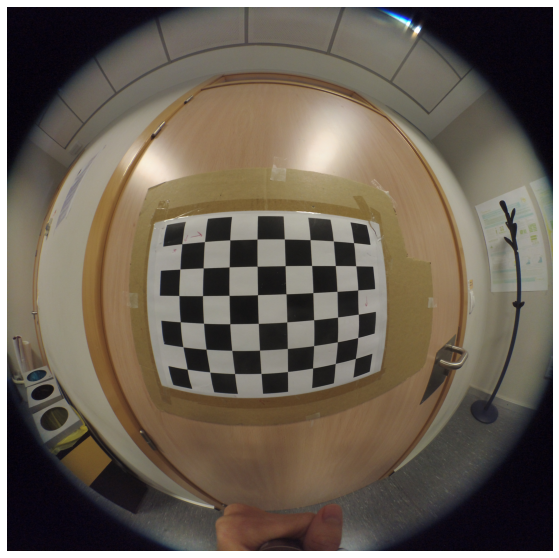
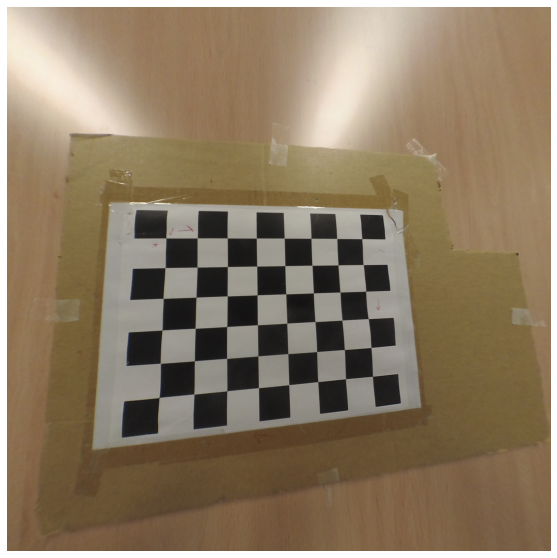


A folder of 26 fisheye calibration images is provided. 
For this particular dataset, the checkerboard pattern used is an 8*6 target, and the square size is 25mm

In addition to performing the calibration, you will also be required to calculate and visualize the reprojection error. The reprojection error is the distance between a pattern keypoint detected in a calibration image, and a corresponding world point projected into the same image. 

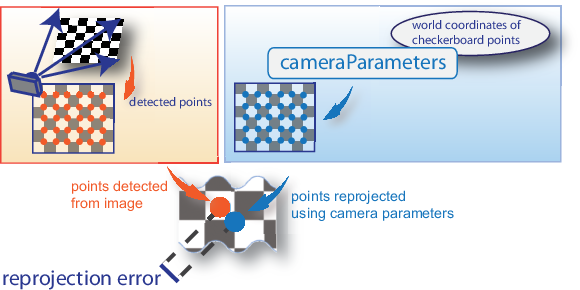

Finally, you will be asked to debug and improve the mean reprojection error, and suggest further improvements to improve calibration accuracy

## Submission Details
Assignment deadline: Midnight, Tuesday 28th Feb \
Jupyter Notebook containing submission to be submitted via blackboard \
Total grade: 10% of final module mark 


# Submission details:
#### Name: Smitesh Nitin Patil
#### ID: 22223696
#### Class code: 1CSD

## Libraries required for this assignment

In [1]:
%matplotlib inline
# import required libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Define calibration parameters
- Define checkerboard shape (rows and columns, defined by the inner corners of the target)
- define the target square size (25mm)
- define the subpix_criteria (note: check online documentation)
- define calibration_flags (again, check online documentation). Hint, don't set the "CALIB_CHECK_COND" flag
- define object points and image point variables

In [2]:
# Define the chess board rows and columns
CHECKERBOARD = (8,6)
SQUARE_SIZE = 25  # square size in mm
subpix_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
#calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_CHECK_COND + cv2.fisheye.CALIB_FIX_SKEW
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)*SQUARE_SIZE

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# define number of images to be used
N_img = 26

## Perform the calibration

Note: there are plenty of online tutorials on this process, feel free to use as a reference. Just be aware that in this example, we will be using the cv2.fisheye.calibrate function - not all tutorials use this function

- Read in all of the calibration images using cv2.imread. Hint: create a list of images
- Convert images to greyscale
- Find the chessboard corners
- Use the cv2.fisheye.calibrate function to calibrate the camera

In [3]:
# load in all images into a list

for img in glob.glob("images\*.jpg"):
    img = cv2.imread(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #loop through images, and find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, calibration_flags)
    
    #If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,np.float32(corners),(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        
    #run fisheye calibration (cv2.fisheye.calibrate)
    N_OK = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    rms, K, D, rvecs, tvecs = cv2.fisheye.calibrate(
            objpoints, imgpoints,
            gray.shape[::-1],
            K, D, rvecs, tvecs,
            calibration_flags,
            subpix_criteria
    )

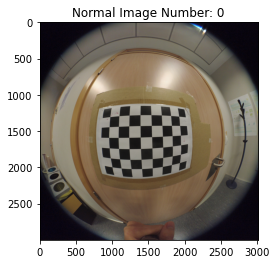

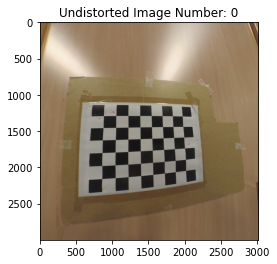

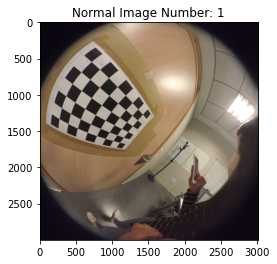

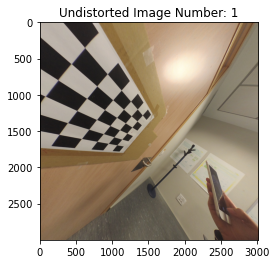

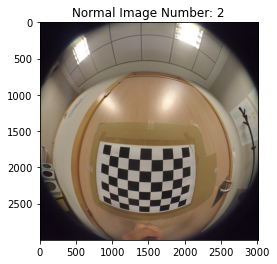

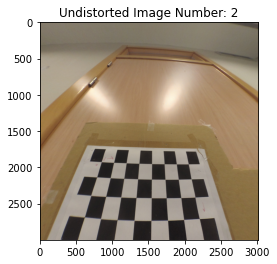

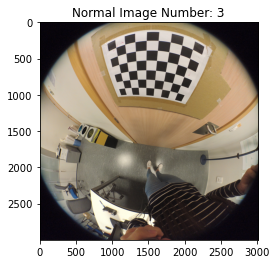

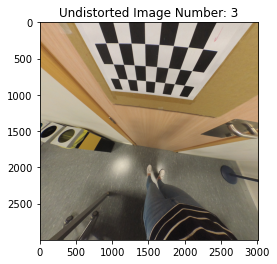

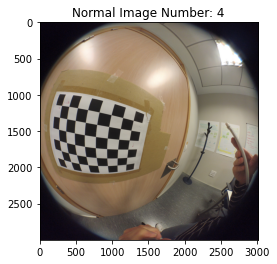

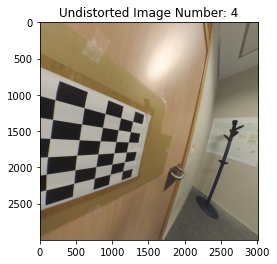

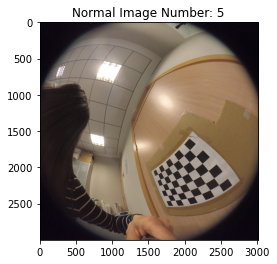

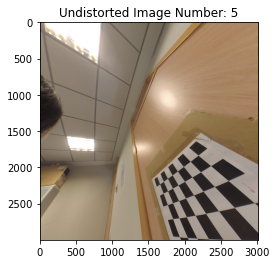

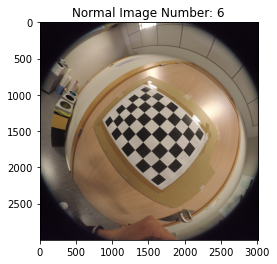

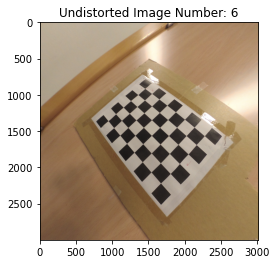

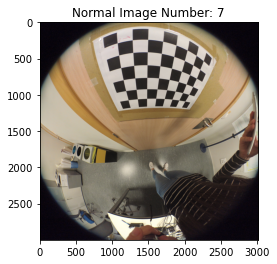

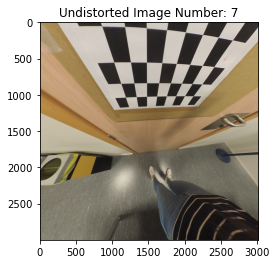

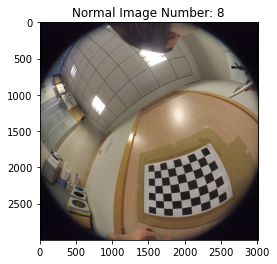

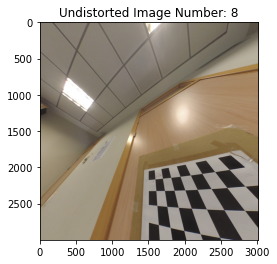

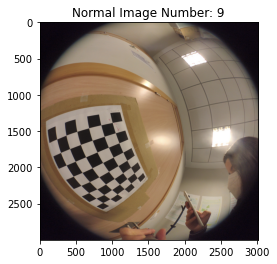

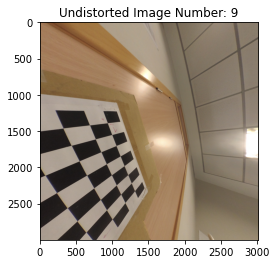

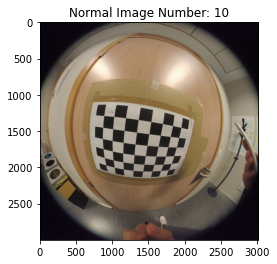

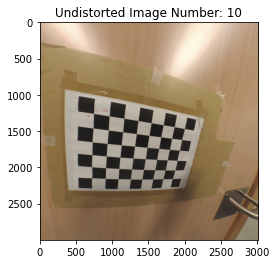

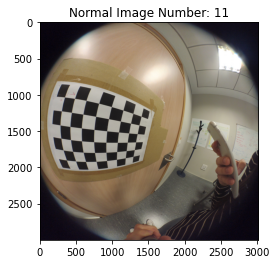

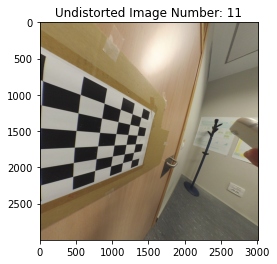

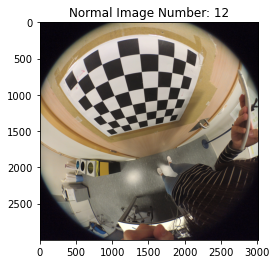

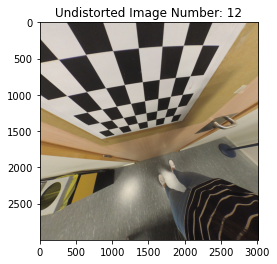

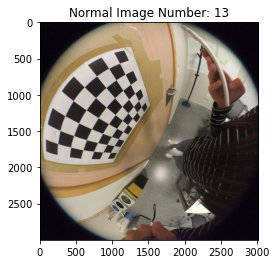

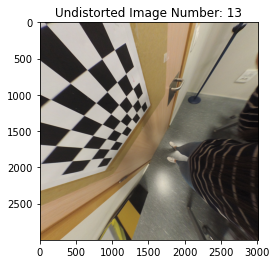

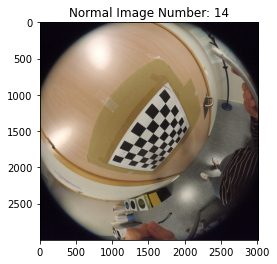

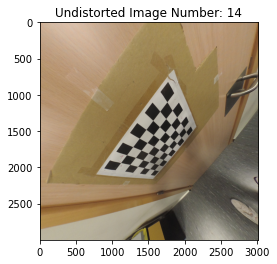

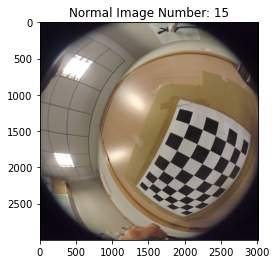

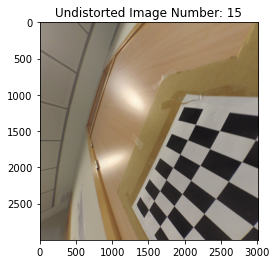

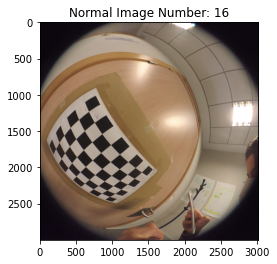

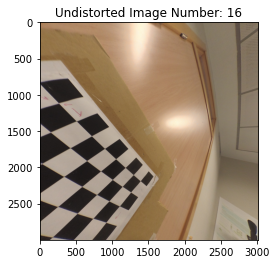

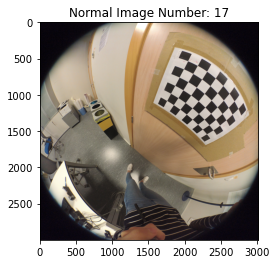

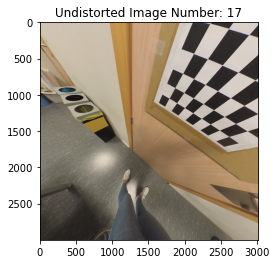

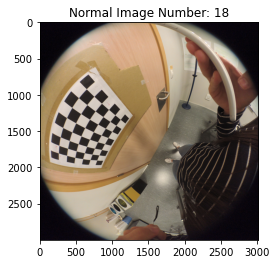

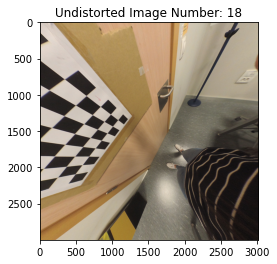

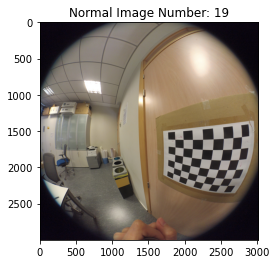

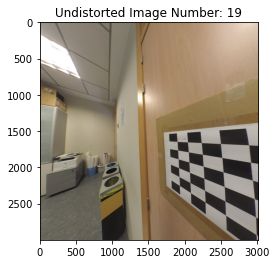

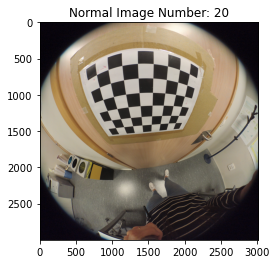

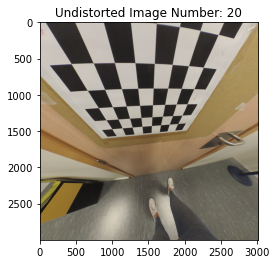

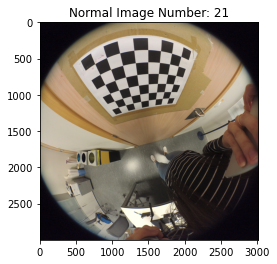

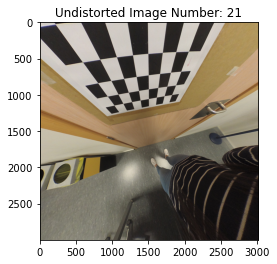

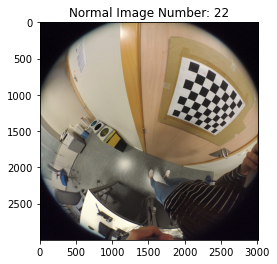

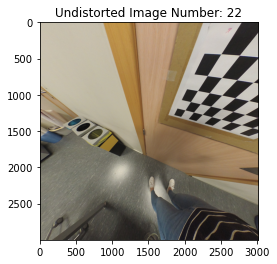

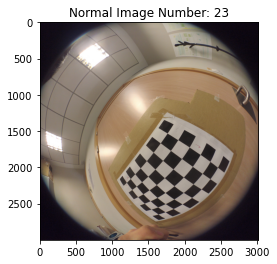

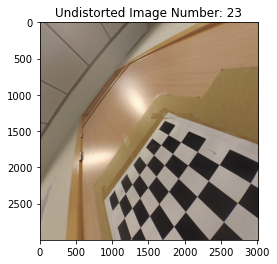

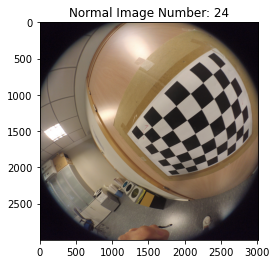

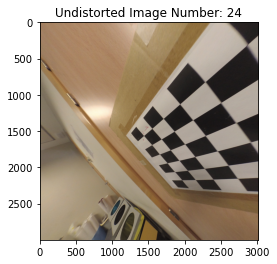

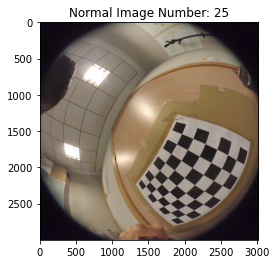

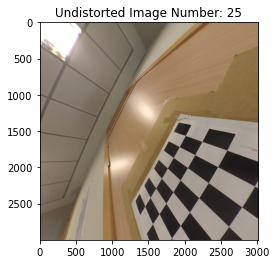

In [8]:
for i, img in enumerate(glob.glob("images/*.jpg")):
    img = cv2.imread(img)
    h, w = img.shape[:2]
    newK, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 0)
    mapx, mapy = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), newK, (w, h), cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, mapx, mapy, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(str("Normal Image Number: "+ str(i+1)))
    plt.show()
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    plt.title(str("Undistorted Image Number: "+ str(i+1)))
    plt.imshow(undistorted_img)
    plt.show()

## Calculate reprojection error
Write a function that calculates the reprojection error
- the function should return both individual projection errors for each image and the average reprojection error for all images
- include a "debug" flag. If debug==True, then plot both the detected points and reprojected points for each image. This is a good way to visualize the accuracy of calibration. The result should look like the image below.

Review both the individual and mean projection errors for your results. It should become apprarant that in some of the images, calibration was not successful...

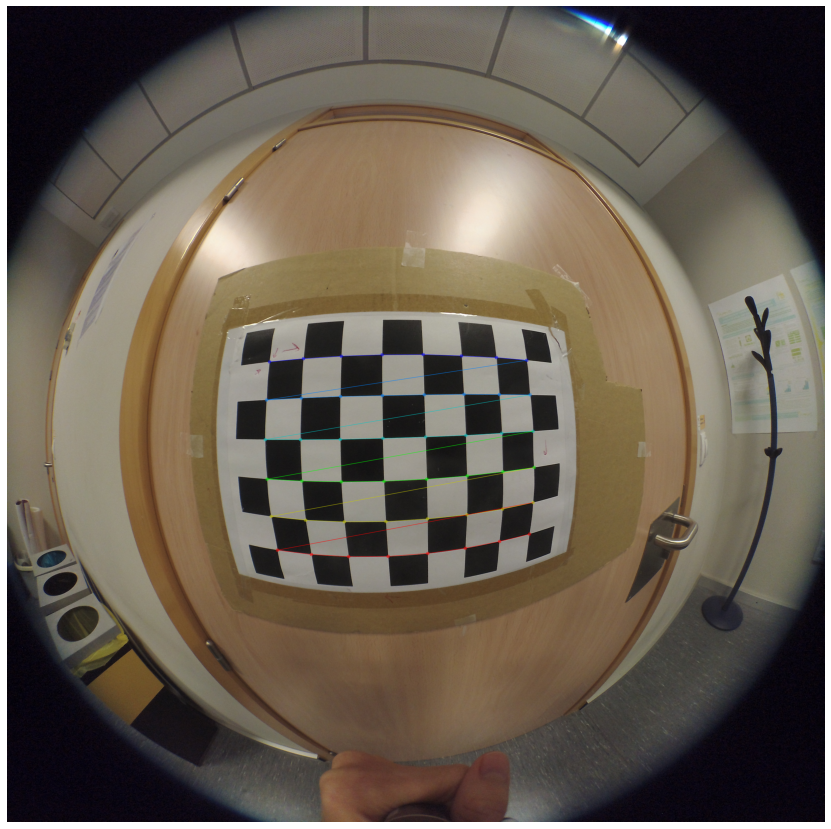

In [ ]:
def calculate_reprojection_error(objpoints, imgpoints, K, D, rvecs, tvecs, debug=False):
    # Project the object points onto the image plane using the estimated intrinsic and distortion parameters
    mean_error = 0
    errors = []
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, D)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        errors.append(error)
    if debug:
        for i, img in enumerate(glob.glob(r"images/*.jpg")):
            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.drawChessboardCorners(image, CHECKERBOARD, imgpoints[i], True)
            plt.imshow(image)
            plt.show()

    # Calculate the average reprojection error
    reprojection_error = np.mean(errors)
    return errors, reprojection_error

In [ ]:
# Calculate the reprojection error for the calibration
# set debug flag
#calculate reprojection error by calling your calculate_reprojection_error function. 
error, reprojection_error = calculate_reprojection_error(objpoints, imgpoints, K, D, rvecs, tvecs, True)

In [ ]:
reprojection_error

## Debug performance
By now, you should have been able to identify a number of images where calibration didn't work:
- suggest possible reasons why calibration didn't work on these images
- Exclude these images from the calibration procedure, and assess the impact on reprojection error


### 1. Suggest possible reasons why calibration didn't work on these images

There are many possible reasons why calibration didn't work on these images.

1. Incorrect Image Orientation : If the images are not correctly positioned, the calibration process will not work correctly. the calibration process needs to match points in the images and if the object is not placed properly the algorithm finds it difficult to calibrate the image.

2. Image quality and distortion : If images have poor resolution, high noise or if the object in image was in motion then it leads to high error during calibration propcess.

3. Calibration parameters : Paramters like calibration flags and critieria can impact drastically on the error for some images compared to others


### 2. Exclude these images from the calibration procedure, and assess the impact on reprojection error



In [ ]:
less_error = []
# looping through images
for i, img in enumerate(glob.glob("images\*.jpg")):
    #if error is less add the index to the list 
    if error[i] <= 500:
        less_error.append(i)

In [ ]:
# subset imgpoints and objpoints based on the index in less_error list
imgpoints1 = [imgpoints[index] for index in less_error]
objpoints1 = [objpoints[index] for index in less_error]

#initalizing varibles again
N_OK = len(objpoints1)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

#recalibrating
rms, K, D, rvecs, tvecs = cv2.fisheye.calibrate(
            objpoints1,
            imgpoints1,
            gray.shape[::-1],
            K,
            D,
            rvecs,
            tvecs,
            calibration_flags,
            (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)
# error with subsetted images
error, reprojection_error = calculate_reprojection_error(objpoints1, imgpoints1, K, D, rvecs, tvecs, False)

In [ ]:
reprojection_error

Thus it is observed that mean reprojection error seems to decrease considerably after excluding images with high error while calibrating